In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import datetime
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
func = lambda x: 0 if x < 0 else x
func1 = lambda x: x if x <0 else 0

In [3]:
# # inputs

# print('enter 1st month OTD in quantity')
# first=input()

# print('enter 2nd month OTD in quantity')
# second=input()

# print('enter 3rd month OTD in quantity')
# third=input()

# print('enter 4th month OTD in quantity')
# fouth=input()

# print('enter 5th month OTD in quantity')
# fifth=input()

# print('enter 6th month OTD in quantity')
# sixth=input()

# print('enter product name')
# yourname=input()

# print('enter leadtime in months')
# leadtime=input()

In [23]:
# first=int(first)
# second=int(second)
# third=int(third)
# fouth=int(fouth)
# fifth=int(fifth)
# sixth=int(sixth)
# leadtime=int(leadtime)

first=200
second=250
third=230
fouth=200
fifth=150
sixth=180
leadtime=2

In [24]:
d=pd.date_range(start='1/1/2022', end='31/01/2023', freq='MS')
df=pd.DataFrame(columns=['date','cls_stk_dpp','open_ord','total','fcast_open_stk','fcast_gds_rec','otd','otd_fcast','recom_topup',
                        'recom_safe_stk','fcast_cls_stk','recom_ord','recom_ord_value','rssl_less_stk',
                        'next_mth_cls_stk'])
df.date=d
df = df.fillna(0)

# system input order for 'cls_stk_dpp' & 'open_ord' and 'total'

df.loc[6,'cls_stk_dpp']=550

df.loc[6,'open_ord']=100

df.total=df.cls_stk_dpp + df.open_ord

# input otd data

# y=[185,49,71,92,189,121]
y=[first,second,third,fouth,fifth, sixth]
df.loc[:5,'otd']=y

# convert dates to ordinal values

df['ord_date'] = [i.toordinal() for i in df.date]

# train data for linear regression

otd_date = df.loc[0:5,'ord_date']

m, b, rv, p, se = stats.linregress(otd_date,y)

# prepare ordinal dates for prediction and convert to list

fcast_date = df.loc[6:11,'ord_date']
fcast_date = fcast_date.tolist()

# forecast prediction using ordinal dates

fcast = [i*m+b for i in fcast_date]

fcast = [i.round(0) for i in fcast]

fcast = [func(i) for i in fcast]

# fill df with predicted values in 'otd_fcast'

df.loc[6:11,'otd_fcast']=fcast

# recommended top up qty

df.loc[6,'recom_topup']=50

# define leadtime



# recommended safety stocks

safe_stks = round(df.loc[6:11,'otd_fcast'].mean()*leadtime,0)
df.loc[6,'recom_safe_stk']=safe_stks

In [25]:
def fillrows(h):
    # forecasted closing stock (O)

    df.loc[h,'fcast_cls_stk'] = df.loc[h,'fcast_open_stk'] + df.loc[h,'fcast_gds_rec'] - df.loc[h,'otd_fcast'] + \
    func1(df.loc[h-1,'fcast_cls_stk'])
    
    
    # forecasted opening stock (G)

    df.loc[h+1,'fcast_open_stk']=func(df.loc[h,'fcast_cls_stk'])
    
    
    # recommended order qty (p)

    b = df.loc[h,'otd_fcast'] + df.loc[h,'recom_topup'] + df.loc[h,'recom_safe_stk'] - df.loc[h,'fcast_open_stk']
    c = func(b)
    df.loc[h,'recom_ord'] = c + df.loc[h+1,'rssl_less_stk']
    
    
    # forecasted goods received (H)

    df.loc[h+1,'fcast_gds_rec'] = df.loc[h,'recom_ord'] + df.loc[h,'open_ord']
    

    # next month closing stock (S)

    df.loc[h,'next_mth_cls_stk']=  safe_stks - df.loc[h,'fcast_cls_stk']
    

    return df

In [26]:
# recommended order qty

# df.loc[7:11,'rssl_less_stk'] = [83,4,140,144,147]
df.loc[7:11,'rssl_less_stk'] = 0

# forecasted closing stock (O)

df.loc[6,'fcast_cls_stk']= df.loc[6,'cls_stk_dpp']-df.loc[6,'otd_fcast']

# forecasted opening stock (G)

df.loc[7,'fcast_open_stk']=func(df.loc[6,'fcast_cls_stk'])


# recommended order qty (P)

b = df.loc[6,'otd_fcast'] + df.loc[6,'recom_topup'] + safe_stks - df.loc[6,'total']
c = func(b)
df.loc[6,'recom_ord'] = c + df.loc[7,'rssl_less_stk']


# forecasted goods received (H)

df.loc[7,'fcast_gds_rec'] = df.loc[6,'recom_ord'] + df.loc[6,'open_ord']

h=7
df = fillrows(h)

h=8
df = fillrows(h)

h=9
df = fillrows(h)

h=10
df = fillrows(h)

h=11
df = fillrows(h)

df

,date,cls_stk_dpp,open_ord,total,fcast_open_stk,fcast_gds_rec,otd,otd_fcast,recom_topup,recom_safe_stk,fcast_cls_stk,recom_ord,recom_ord_value,rssl_less_stk,next_mth_cls_stk,ord_date
0,2022-01-01,0,0,0,0.0,0.0,200,0.0,0,0,0.0,0.0,0,0,0.0,738156
1,2022-02-01,0,0,0,0.0,0.0,250,0.0,0,0,0.0,0.0,0,0,0.0,738187
2,2022-03-01,0,0,0,0.0,0.0,230,0.0,0,0,0.0,0.0,0,0,0.0,738215
3,2022-04-01,0,0,0,0.0,0.0,200,0.0,0,0,0.0,0.0,0,0,0.0,738246
4,2022-05-01,0,0,0,0.0,0.0,150,0.0,0,0,0.0,0.0,0,0,0.0,738276
5,2022-06-01,0,0,0,0.0,0.0,180,0.0,0,0,0.0,0.0,0,0,0.0,738307
6,2022-07-01,50,50,100,0.0,0.0,0,159.0,50,254,-109.0,363.0,0,0,0.0,738337
7,2022-08-01,0,0,0,0.0,413.0,0,146.0,0,0,158.0,146.0,0,0,96.0,738368
8,2022-09-01,0,0,0,158.0,146.0,0,133.0,0,0,171.0,0.0,0,0,83.0,738399
9,2022-10-01,0,0,0,171.0,0.0,0,121.0,0,0,50.0,0.0,0,0,204.0,738429


In [27]:
a_ = df.loc[7,'next_mth_cls_stk']
a_

96.0

In [28]:
# recommended order qty

# df.loc[7:11,'rssl_less_stk'] = [83,4,140,144,147]
df.loc[7:11,'rssl_less_stk'] = [a_,0,0,0,0]

# forecasted closing stock (O)

df.loc[6,'fcast_cls_stk']= df.loc[6,'cls_stk_dpp']-df.loc[6,'otd_fcast']

# forecasted opening stock (G)

df.loc[7,'fcast_open_stk']=func(df.loc[6,'fcast_cls_stk'])


# recommended order qty (P)

b = df.loc[6,'otd_fcast'] + df.loc[6,'recom_topup'] + safe_stks - df.loc[6,'total']
c = func(b)
df.loc[6,'recom_ord'] = c + df.loc[7,'rssl_less_stk']


# forecasted goods received (H)

df.loc[7,'fcast_gds_rec'] = df.loc[6,'recom_ord'] + df.loc[6,'open_ord']

h=7
df = fillrows(h)

h=8
df = fillrows(h)

h=9
df = fillrows(h)

h=10
df = fillrows(h)

h=11
df = fillrows(h)

df

,date,cls_stk_dpp,open_ord,total,fcast_open_stk,fcast_gds_rec,otd,otd_fcast,recom_topup,recom_safe_stk,fcast_cls_stk,recom_ord,recom_ord_value,rssl_less_stk,next_mth_cls_stk,ord_date
0,2022-01-01,0,0,0,0.0,0.0,200,0.0,0,0,0.0,0.0,0,0.0,0.0,738156
1,2022-02-01,0,0,0,0.0,0.0,250,0.0,0,0,0.0,0.0,0,0.0,0.0,738187
2,2022-03-01,0,0,0,0.0,0.0,230,0.0,0,0,0.0,0.0,0,0.0,0.0,738215
3,2022-04-01,0,0,0,0.0,0.0,200,0.0,0,0,0.0,0.0,0,0.0,0.0,738246
4,2022-05-01,0,0,0,0.0,0.0,150,0.0,0,0,0.0,0.0,0,0.0,0.0,738276
5,2022-06-01,0,0,0,0.0,0.0,180,0.0,0,0,0.0,0.0,0,0.0,0.0,738307
6,2022-07-01,50,50,100,0.0,0.0,0,159.0,50,254,-109.0,459.0,0,0.0,0.0,738337
7,2022-08-01,0,0,0,0.0,509.0,0,146.0,0,0,254.0,146.0,0,96.0,0.0,738368
8,2022-09-01,0,0,0,254.0,146.0,0,133.0,0,0,267.0,0.0,0,0.0,-13.0,738399
9,2022-10-01,0,0,0,267.0,0.0,0,121.0,0,0,146.0,0.0,0,0.0,108.0,738429


In [29]:
b_ = df.loc[8,'next_mth_cls_stk']
b_

-13.0

In [30]:
# recommended order qty

# df.loc[7:11,'rssl_less_stk'] = [83,4,140,144,147]
df.loc[7:11,'rssl_less_stk'] = [a_,b_,0,0,0]

# forecasted closing stock (O)

df.loc[6,'fcast_cls_stk']= df.loc[6,'cls_stk_dpp']-df.loc[6,'otd_fcast']

# forecasted opening stock (G)

df.loc[7,'fcast_open_stk']=func(df.loc[6,'fcast_cls_stk'])


# recommended order qty (P)

b = df.loc[6,'otd_fcast'] + df.loc[6,'recom_topup'] + safe_stks - df.loc[6,'total']
c = func(b)
df.loc[6,'recom_ord'] = c + df.loc[7,'rssl_less_stk']


# forecasted goods received (H)

df.loc[7,'fcast_gds_rec'] = df.loc[6,'recom_ord'] + df.loc[6,'open_ord']

h=7
df = fillrows(h)

h=8
df = fillrows(h)

h=9
df = fillrows(h)

h=10
df = fillrows(h)

h=11
df = fillrows(h)

df

,date,cls_stk_dpp,open_ord,total,fcast_open_stk,fcast_gds_rec,otd,otd_fcast,recom_topup,recom_safe_stk,fcast_cls_stk,recom_ord,recom_ord_value,rssl_less_stk,next_mth_cls_stk,ord_date
0,2022-01-01,0,0,0,0.0,0.0,200,0.0,0,0,0.0,0.0,0,0.0,0.0,738156
1,2022-02-01,0,0,0,0.0,0.0,250,0.0,0,0,0.0,0.0,0,0.0,0.0,738187
2,2022-03-01,0,0,0,0.0,0.0,230,0.0,0,0,0.0,0.0,0,0.0,0.0,738215
3,2022-04-01,0,0,0,0.0,0.0,200,0.0,0,0,0.0,0.0,0,0.0,0.0,738246
4,2022-05-01,0,0,0,0.0,0.0,150,0.0,0,0,0.0,0.0,0,0.0,0.0,738276
5,2022-06-01,0,0,0,0.0,0.0,180,0.0,0,0,0.0,0.0,0,0.0,0.0,738307
6,2022-07-01,50,50,100,0.0,0.0,0,159.0,50,254,-109.0,459.0,0,0.0,0.0,738337
7,2022-08-01,0,0,0,0.0,509.0,0,146.0,0,0,254.0,133.0,0,96.0,0.0,738368
8,2022-09-01,0,0,0,254.0,133.0,0,133.0,0,0,254.0,0.0,0,-13.0,0.0,738399
9,2022-10-01,0,0,0,254.0,0.0,0,121.0,0,0,133.0,0.0,0,0.0,121.0,738429


In [31]:
c_ = df.loc[9,'next_mth_cls_stk']
c_

121.0

In [32]:
a_,b_

(96.0, -13.0)

In [33]:
df

,date,cls_stk_dpp,open_ord,total,fcast_open_stk,fcast_gds_rec,otd,otd_fcast,recom_topup,recom_safe_stk,fcast_cls_stk,recom_ord,recom_ord_value,rssl_less_stk,next_mth_cls_stk,ord_date
0,2022-01-01,0,0,0,0.0,0.0,200,0.0,0,0,0.0,0.0,0,0.0,0.0,738156
1,2022-02-01,0,0,0,0.0,0.0,250,0.0,0,0,0.0,0.0,0,0.0,0.0,738187
2,2022-03-01,0,0,0,0.0,0.0,230,0.0,0,0,0.0,0.0,0,0.0,0.0,738215
3,2022-04-01,0,0,0,0.0,0.0,200,0.0,0,0,0.0,0.0,0,0.0,0.0,738246
4,2022-05-01,0,0,0,0.0,0.0,150,0.0,0,0,0.0,0.0,0,0.0,0.0,738276
5,2022-06-01,0,0,0,0.0,0.0,180,0.0,0,0,0.0,0.0,0,0.0,0.0,738307
6,2022-07-01,50,50,100,0.0,0.0,0,159.0,50,254,-109.0,459.0,0,0.0,0.0,738337
7,2022-08-01,0,0,0,0.0,509.0,0,146.0,0,0,254.0,133.0,0,96.0,0.0,738368
8,2022-09-01,0,0,0,254.0,133.0,0,133.0,0,0,254.0,0.0,0,-13.0,0.0,738399
9,2022-10-01,0,0,0,254.0,0.0,0,121.0,0,0,133.0,0.0,0,0.0,121.0,738429


In [34]:
# recommended order qty

# df.loc[7:11,'rssl_less_stk'] = [83,4,140,144,147]
df.loc[7:11,'rssl_less_stk'] = [a_,b_,c_,0,0]

## ROW 6
# forecasted closing stock (O)

df.loc[6,'fcast_cls_stk']= df.loc[6,'cls_stk_dpp']-df.loc[6,'otd_fcast']

# forecasted opening stock (G)

df.loc[7,'fcast_open_stk']=func(df.loc[6,'fcast_cls_stk'])


# recommended order qty (P)

b = df.loc[6,'otd_fcast'] + df.loc[6,'recom_topup'] + safe_stks - df.loc[6,'total']
c = func(b)
df.loc[6,'recom_ord'] = c + df.loc[7,'rssl_less_stk']


# forecasted goods received (H)

df.loc[7,'fcast_gds_rec'] = df.loc[6,'recom_ord'] + df.loc[6,'open_ord']

h=7
df = fillrows(h)

h=8
df = fillrows(h)

h=9
df = fillrows(h)

h=10
df = fillrows(h)

h=11
df = fillrows(h)

df

,date,cls_stk_dpp,open_ord,total,fcast_open_stk,fcast_gds_rec,otd,otd_fcast,recom_topup,recom_safe_stk,fcast_cls_stk,recom_ord,recom_ord_value,rssl_less_stk,next_mth_cls_stk,ord_date
0,2022-01-01,0,0,0,0.0,0.0,200,0.0,0,0,0.0,0.0,0,0.0,0.0,738156
1,2022-02-01,0,0,0,0.0,0.0,250,0.0,0,0,0.0,0.0,0,0.0,0.0,738187
2,2022-03-01,0,0,0,0.0,0.0,230,0.0,0,0,0.0,0.0,0,0.0,0.0,738215
3,2022-04-01,0,0,0,0.0,0.0,200,0.0,0,0,0.0,0.0,0,0.0,0.0,738246
4,2022-05-01,0,0,0,0.0,0.0,150,0.0,0,0,0.0,0.0,0,0.0,0.0,738276
5,2022-06-01,0,0,0,0.0,0.0,180,0.0,0,0,0.0,0.0,0,0.0,0.0,738307
6,2022-07-01,50,50,100,0.0,0.0,0,159.0,50,254,-109.0,459.0,0,0.0,0.0,738337
7,2022-08-01,0,0,0,0.0,509.0,0,146.0,0,0,254.0,133.0,0,96.0,0.0,738368
8,2022-09-01,0,0,0,254.0,133.0,0,133.0,0,0,254.0,121.0,0,-13.0,0.0,738399
9,2022-10-01,0,0,0,254.0,121.0,0,121.0,0,0,254.0,0.0,0,121.0,0.0,738429


In [35]:
d_ = df.loc[10,'next_mth_cls_stk']
d_

108.0

In [36]:
# recommended order qty

# df.loc[7:11,'rssl_less_stk'] = [83,4,140,144,147]
df.loc[7:11,'rssl_less_stk'] = [a_,b_,c_,d_,0]

## ROW 6
# forecasted closing stock (O)

df.loc[6,'fcast_cls_stk']= df.loc[6,'cls_stk_dpp']-df.loc[6,'otd_fcast']

# forecasted opening stock (G)

df.loc[7,'fcast_open_stk']=func(df.loc[6,'fcast_cls_stk'])


# recommended order qty (P)

b = df.loc[6,'otd_fcast'] + df.loc[6,'recom_topup'] + safe_stks - df.loc[6,'total']
c = func(b)
df.loc[6,'recom_ord'] = c + df.loc[7,'rssl_less_stk']


# forecasted goods received (H)

df.loc[7,'fcast_gds_rec'] = df.loc[6,'recom_ord'] + df.loc[6,'open_ord']

h=7
df = fillrows(h)

h=8
df = fillrows(h)

h=9
df = fillrows(h)

h=10
df = fillrows(h)

h=11
df = fillrows(h)

df

,date,cls_stk_dpp,open_ord,total,fcast_open_stk,fcast_gds_rec,otd,otd_fcast,recom_topup,recom_safe_stk,fcast_cls_stk,recom_ord,recom_ord_value,rssl_less_stk,next_mth_cls_stk,ord_date
0,2022-01-01,0,0,0,0.0,0.0,200,0.0,0,0,0.0,0.0,0,0.0,0.0,738156
1,2022-02-01,0,0,0,0.0,0.0,250,0.0,0,0,0.0,0.0,0,0.0,0.0,738187
2,2022-03-01,0,0,0,0.0,0.0,230,0.0,0,0,0.0,0.0,0,0.0,0.0,738215
3,2022-04-01,0,0,0,0.0,0.0,200,0.0,0,0,0.0,0.0,0,0.0,0.0,738246
4,2022-05-01,0,0,0,0.0,0.0,150,0.0,0,0,0.0,0.0,0,0.0,0.0,738276
5,2022-06-01,0,0,0,0.0,0.0,180,0.0,0,0,0.0,0.0,0,0.0,0.0,738307
6,2022-07-01,50,50,100,0.0,0.0,0,159.0,50,254,-109.0,459.0,0,0.0,0.0,738337
7,2022-08-01,0,0,0,0.0,509.0,0,146.0,0,0,254.0,133.0,0,96.0,0.0,738368
8,2022-09-01,0,0,0,254.0,133.0,0,133.0,0,0,254.0,121.0,0,-13.0,0.0,738399
9,2022-10-01,0,0,0,254.0,121.0,0,121.0,0,0,254.0,108.0,0,121.0,0.0,738429


In [37]:
e_ = df.loc[11,'next_mth_cls_stk']
e_

96.0

In [38]:
# recommended order qty

# df.loc[7:11,'rssl_less_stk'] = [83,4,140,144,147]
df.loc[7:11,'rssl_less_stk'] = [a_,b_,c_,d_,e_]

## ROW 6
# forecasted closing stock (O)

df.loc[6,'fcast_cls_stk']= df.loc[6,'cls_stk_dpp']-df.loc[6,'otd_fcast']

# forecasted opening stock (G)

df.loc[7,'fcast_open_stk']=func(df.loc[6,'fcast_cls_stk'])


# recommended order qty (P)

b = df.loc[6,'otd_fcast'] + df.loc[6,'recom_topup'] + safe_stks - df.loc[6,'total']
c = func(b)
df.loc[6,'recom_ord'] = c + df.loc[7,'rssl_less_stk']


# forecasted goods received (H)

df.loc[7,'fcast_gds_rec'] = df.loc[6,'recom_ord'] + df.loc[6,'open_ord']

h=7
df = fillrows(h)

h=8
df = fillrows(h)

h=9
df = fillrows(h)

h=10
df = fillrows(h)

h=11
df = fillrows(h)

df

,date,cls_stk_dpp,open_ord,total,fcast_open_stk,fcast_gds_rec,otd,otd_fcast,recom_topup,recom_safe_stk,fcast_cls_stk,recom_ord,recom_ord_value,rssl_less_stk,next_mth_cls_stk,ord_date
0,2022-01-01,0,0,0,0.0,0.0,200,0.0,0,0,0.0,0.0,0,0.0,0.0,738156
1,2022-02-01,0,0,0,0.0,0.0,250,0.0,0,0,0.0,0.0,0,0.0,0.0,738187
2,2022-03-01,0,0,0,0.0,0.0,230,0.0,0,0,0.0,0.0,0,0.0,0.0,738215
3,2022-04-01,0,0,0,0.0,0.0,200,0.0,0,0,0.0,0.0,0,0.0,0.0,738246
4,2022-05-01,0,0,0,0.0,0.0,150,0.0,0,0,0.0,0.0,0,0.0,0.0,738276
5,2022-06-01,0,0,0,0.0,0.0,180,0.0,0,0,0.0,0.0,0,0.0,0.0,738307
6,2022-07-01,50,50,100,0.0,0.0,0,159.0,50,254,-109.0,459.0,0,0.0,0.0,738337
7,2022-08-01,0,0,0,0.0,509.0,0,146.0,0,0,254.0,133.0,0,96.0,0.0,738368
8,2022-09-01,0,0,0,254.0,133.0,0,133.0,0,0,254.0,121.0,0,-13.0,0.0,738399
9,2022-10-01,0,0,0,254.0,121.0,0,121.0,0,0,254.0,108.0,0,121.0,0.0,738429


In [39]:
df.recom_ord = [func(i) for i in df.recom_ord]
df.fcast_gds_rec = [func(i) for i in df.fcast_gds_rec]
df.otd_fcast = [func(i) for i in df.otd_fcast]
df

,date,cls_stk_dpp,open_ord,total,fcast_open_stk,fcast_gds_rec,otd,otd_fcast,recom_topup,recom_safe_stk,fcast_cls_stk,recom_ord,recom_ord_value,rssl_less_stk,next_mth_cls_stk,ord_date
0,2022-01-01,0,0,0,0.0,0.0,200,0.0,0,0,0.0,0.0,0,0.0,0.0,738156
1,2022-02-01,0,0,0,0.0,0.0,250,0.0,0,0,0.0,0.0,0,0.0,0.0,738187
2,2022-03-01,0,0,0,0.0,0.0,230,0.0,0,0,0.0,0.0,0,0.0,0.0,738215
3,2022-04-01,0,0,0,0.0,0.0,200,0.0,0,0,0.0,0.0,0,0.0,0.0,738246
4,2022-05-01,0,0,0,0.0,0.0,150,0.0,0,0,0.0,0.0,0,0.0,0.0,738276
5,2022-06-01,0,0,0,0.0,0.0,180,0.0,0,0,0.0,0.0,0,0.0,0.0,738307
6,2022-07-01,50,50,100,0.0,0.0,0,159.0,50,254,-109.0,459.0,0,0.0,0.0,738337
7,2022-08-01,0,0,0,0.0,509.0,0,146.0,0,0,254.0,133.0,0,96.0,0.0,738368
8,2022-09-01,0,0,0,254.0,133.0,0,133.0,0,0,254.0,121.0,0,-13.0,0.0,738399
9,2022-10-01,0,0,0,254.0,121.0,0,121.0,0,0,254.0,108.0,0,121.0,0.0,738429


In [40]:
df.otd.replace(0,np.nan, inplace=True)
df.loc[:6,'otd_fcast'].replace(0,np.nan, inplace=True)
df.loc[:6,'recom_ord'].replace(0, np.nan, inplace=True)
df.fcast_cls_stk.replace(0, np.nan, inplace=True)

Insufficient stocks on 2022-07-01 00:00:00


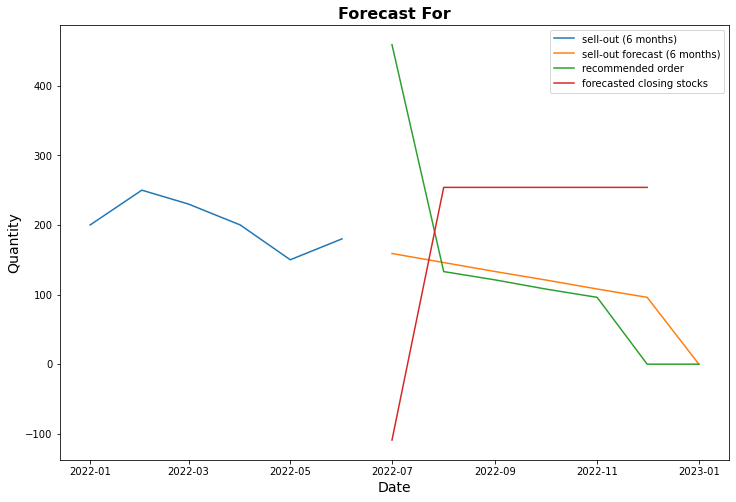

In [41]:
for d, i in zip(df.date, df.fcast_cls_stk):
    if i <= 0:
        print(f"Insufficient stocks on {d}")

plt.figure(figsize=(12,8))

sns.lineplot(data=df, x='date', y='otd')
sns.lineplot(data=df, x='date', y='otd_fcast')
sns.lineplot(data=df, x='date', y='recom_ord')
sns.lineplot(data=df, x='date', y='fcast_cls_stk')
plt.legend(['sell-out (6 months)','sell-out forecast (6 months)','recommended order','forecasted closing stocks'])
plt.title(f"Forecast For", fontsize=16, fontweight='heavy')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Quantity', fontsize=14)
plt.show()

In [ ]:
df.loc[7,'next_mth_cls_stk']

In [ ]:
df = runfc(83,7)
df

In [ ]:
df.loc[8,'next_mth_cls_stk']

In [ ]:
df=runfc(4,8)
df

In [ ]:
for r in range(7,13):
    x = df.loc[r,'next_mth_cls_stk']
    df = runfc(x,r)

In [ ]:
df